In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from timeit import timeit
from IPython.display import display
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from joblib import dump, load
from imblearn.under_sampling import RandomUnderSampler
import shap

In [2]:
from compiledataset import load_dataset, compile_dataset

PATH = "/home/hampus/miun/master_thesis/Datasets"

datasets = {}

# dataset: pd.DataFrame = load_dataset(PATH + "/ORNL", "data_a.csv")
# dataset["remarks"] = "No DLC available"
# datasets["ROAD"] = dataset.to_dict("records")

# dataset: pd.DataFrame = load_dataset(PATH + "/Survival", "data.csv") #, "Malfunction_dataset_SONATA")
# dataset["remarks"] = "-"
# datasets["Survival"] = dataset.to_dict("records")

dataset: pd.DataFrame = load_dataset(PATH + "/Hisingen", "data.csv", "Vehicle_F-Model_2-Fabrication_attack-Sample_1")
dataset["remarks"] = "-"
datasets["Hisingen"] = dataset.to_dict("records")


df = compile_dataset(datasets)
df.drop(columns=["data", "data_dec", "ID", "DLC", "t"], inplace=True, errors="ignore")
df.drop(columns=["d0", "d1", "d2", "d3", "d4", "d5", "d6", "d7"], inplace=True, errors="ignore")

dataset = None # Release memory, as it isn't used for now
datasets = None

display(df)

,dcs,dcs_ID,dt,dt_ID,dt_data,name,class,dataset,type,Label
0,0.368598,0.087271,0.000395,0.025000,0.500769,Vehicle_F-Model_2-Fabrication_attack-Sample_1,modelF,Hisingen,fabr,0
1,0.359375,0.123731,0.000237,0.025000,0.500769,Vehicle_F-Model_2-Fabrication_attack-Sample_1,modelF,Hisingen,fabr,0
2,0.421875,0.103176,0.000240,0.015000,1.021278,Vehicle_F-Model_2-Fabrication_attack-Sample_1,modelF,Hisingen,fabr,0
3,0.328125,0.017021,0.000240,0.025000,0.108807,Vehicle_F-Model_2-Fabrication_attack-Sample_1,modelF,Hisingen,fabr,0
4,0.515625,0.003906,0.000246,0.025000,0.028572,Vehicle_F-Model_2-Fabrication_attack-Sample_1,modelF,Hisingen,fabr,0
...,...,...,...,...,...,...,...,...,...,...
609639,0.515625,0.156250,0.000238,0.023861,1.753402,Vehicle_F-Model_2-Fabrication_attack-Sample_1,modelF,Hisingen,fabr,0
609640,0.281250,0.000000,0.000244,0.023860,0.023860,Vehicle_F-Model_2-Fabrication_attack-Sample_1,modelF,Hisingen,fabr,0
609641,0.265625,0.031250,0.000244,0.068696,1.612886,Vehicle_F-Model_2-Fabrication_attack-Sample_1,modelF,Hisingen,fabr,0
609642,0.171875,0.000000,0.000168,0.052166,0.052166,Vehicle_F-Model_2-Fabrication_attack-Sample_1,modelF,Hisingen,fabr,0


In [3]:
df = df.loc[df["type"] != "masq"]
# df = df.loc[(df["type"] == "fuzz") | (df["type"] == "none")]

In [4]:
# from sklearn.preprocessing import StandardScaler, RobustScaler

# X_train_original = df.copy()

# feature_columns= list(set(df.columns.to_list()).difference(["name", "class", "dataset", "type", "Label"]))

# for col in feature_columns:
#     scaler = RobustScaler().fit(df.loc[df["Label"] == 0, df.columns == col])
#     df.loc[:, df.columns == col] = scaler.transform(df.loc[:, df.columns == col])

# from pp_tools import scale_dataset
# df_original = df.drop(columns=["type", "dataset", "name", "class", "Label"]).copy()
# scale_dataset(df)
# display(df)

In [5]:
X_train = df.drop(columns="Label")
y_train = df["Label"]

df = None # Release memory

# Split dataset into training and test data, stratify by the name of the dataset
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=0, shuffle=True, stratify=X_train["name"])

In [6]:
rus = RandomUnderSampler(random_state=0)
X_train, y_train = rus.fit_resample(X_train, y_train)
X_test, y_test = rus.fit_resample(X_test, y_test)
bintr = np.bincount(y_train)
binte = np.bincount(y_test)
print(f"Labels\t\tTraining\tTesting\nNormal\t\t{bintr[0]}\t\t{binte[0]}\nAttack\t\t{bintr[1]}\t\t{binte[1]}")

Labels		Training	Testing
Normal		351		136
Attack		351		136


In [7]:
X_train.drop(columns=["type", "dataset", "name", "class"], inplace=True, errors="ignore")
X_test.drop(columns=["type", "dataset", "name", "class"], inplace=True, errors="ignore")

Deep Neural Network

In [8]:
from pp_tools import scale_dataset

X_train_original = X_train.copy()
X_test_original = X_test.copy()

X_combined = pd.concat([X_train, X_test])

scale_dataset(X_combined)

test_len = len(X_test)
X_test = X_combined.iloc[-test_len:]
X_train = X_combined.iloc[:-test_len]

X_combined = None # Release memory

In [9]:
import keras
from keras import layers

# dnn = keras.models.Sequential(
#     [
#         keras.Input(shape=(len(X_train.columns),), name="input"),
#         layers.Dense(11, activation='relu', name="layer_1", kernel_initializer="glorot_normal"),
#         layers.Dense(23, activation='relu', name="layer_2", kernel_initializer="glorot_normal"),
#         layers.Dense(7, activation='relu', name="layer_3", kernel_initializer="glorot_normal"),
#         layers.Dense(1, activation='sigmoid', name="output", kernel_initializer="glorot_normal")
#     ]
# )



# dnn.compile(
#     optimizer="adam",  # Optimizer rmsprop
#     # Loss function to minimize
#     loss=keras.losses.BinaryCrossentropy(),
#     # List of metrics to monitor
#     metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall(), keras.metrics.FalseNegatives()],
# )

dnn = keras.models.load_model("dnn_all")

val_percent = int(len(y_train) * 0.1)
X_val = X_train.sample(val_percent, random_state=0)
y_val = y_train.loc[X_val.index]
X_train = X_train.loc[~X_train.index.isin(X_val)]
y_train = y_train.loc[~y_train.index.isin(X_val)]

# dnn.fit(
#     X_train,
#     y_train,
#     batch_size=200,
#     epochs=20,
#     # We pass some validation for
#     # monitoring validation loss and metrics
#     # at the end of each epoch
#     validation_data=(X_val, y_val),
#     callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)]
# )

# dnn.save("dnn_all_hisingen")

# results = dnn.evaluate(X_test, y_test, batch_size=128)
# print("test loss, test acc:", results)

Epoch 1/20
4/4 [==============================] - 1s 75ms/step - loss: 0.7818 - binary_accuracy: 0.2265 - recall: 0.0057 - false_negatives: 349.0000 - val_loss: 0.8048 - val_binary_accuracy: 0.2000 - val_recall: 0.0000e+00 - val_false_negatives: 42.0000
Epoch 2/20
4/4 [==============================] - 0s 7ms/step - loss: 0.7564 - binary_accuracy: 0.2664 - recall: 0.0114 - false_negatives: 347.0000 - val_loss: 0.7755 - val_binary_accuracy: 0.2857 - val_recall: 0.0000e+00 - val_false_negatives: 42.0000
Epoch 3/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7336 - binary_accuracy: 0.3504 - recall: 0.0342 - false_negatives: 339.0000 - val_loss: 0.7500 - val_binary_accuracy: 0.3429 - val_recall: 0.0000e+00 - val_false_negatives: 42.0000
Epoch 4/20
4/4 [==============================] - 0s 12ms/step - loss: 0.7149 - binary_accuracy: 0.4416 - recall: 0.0598 - false_negatives: 330.0000 - val_loss: 0.7281 - val_binary_accuracy: 0.3714 - val_recall: 0.0476 - val_false_negatives

In [10]:
from sklearn.metrics import cohen_kappa_score, f1_score, accuracy_score, matthews_corrcoef

pred_train = np.round(dnn.predict(X_train))

f1_scores = f1_score(y_train, pred_train, average='weighted')
print("Training F1:  %0.4f (+/- %0.4f)" % (f1_scores.mean(), f1_scores.std()))

proba_test = dnn.predict(X_test)
pred_test = np.round(proba_test)



acc_scores = accuracy_score(y_test, pred_test)
print("Testing Accuracy:  %0.4f (+/- %0.4f)" % (acc_scores.mean(), acc_scores.std()))

f1_scores = f1_score(y_test, pred_test, average='weighted')
print("Testing F1:  %0.4f (+/- %0.4f)" % (f1_scores.mean(), f1_scores.std()))

matt_scores = matthews_corrcoef(y_test, pred_test)
print("Testing Matthews corr:  %0.4f (+/- %0.4f)" % (matt_scores.mean(), matt_scores.std()))

kappa_scores = cohen_kappa_score(y_test, pred_test)
print("Kappa score:  %0.4f(+/- %0.4f)" % (kappa_scores.mean(), kappa_scores.std()))

Training F1:  0.8566 (+/- 0.0000)
Testing Accuracy:  0.8860 (+/- 0.0000)
Testing F1:  0.8847 (+/- 0.0000)
Testing Matthews corr:  0.7902 (+/- 0.0000)
Kappa score:  0.7721(+/- 0.0000)


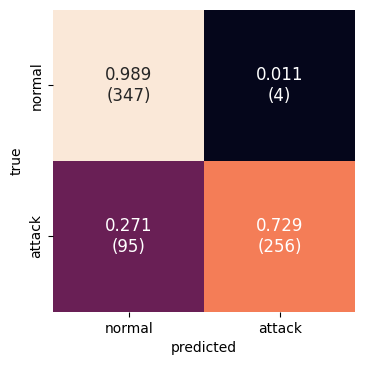

In [11]:
from plot_tools import plot_confusion_matrix

plot_confusion_matrix(y_train, pred_train, "DNN, \"Survival\", all attacks, training data\n(# of instances)", cbar=False)

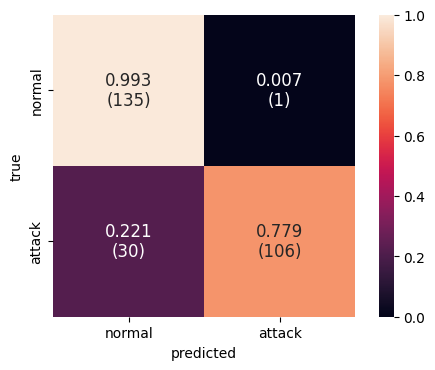

In [12]:
plot_confusion_matrix(y_test, pred_test, "DNN, \"Survival\", all attacks, testing data\n(# of instances)")

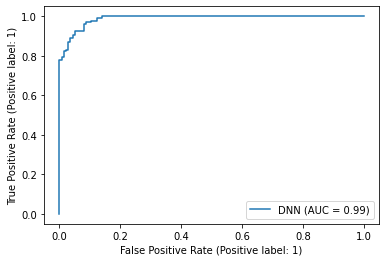

In [13]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test, proba_test, name="DNN")

In [14]:
import shap

exp = shap.KernelExplainer(dnn, data=X_train.sample(100, random_state=1))
print(exp.expected_value)

[0.47486223]


In [15]:
from shap_tools import *

X_exp = X_train.sample(min(len(X_train), 600), random_state=0)
y_exp = y_train[X_exp.index]
X_exp_original = X_train_original.loc[X_exp.index]
# print(X_exp)
# print(X_exp_original)

# Make sure that the ingested SHAP model (a TreeEnsemble object) makes the
# same predictions as the original model
# assert np.abs(exp.model.predict(X_exp) - dnn.predict_proba(X_exp)).max() < 1e-4


# # Make sure the SHAP values sum up to the model output (this is the local accuracy property)
# assert np.abs((shap_all.base_values + shap_all.values).sum(1) - clf.predict_proba(X_train)).max() < 1e-4

# print(len(X_train.loc[y_train != pred]))
# print(len(X_train.loc[y_train == pred]))
# shap_false = get_explanation(exp, X_train.loc[y_train != pred])
# shap_FP = get_explanation(exp, X_train.loc[(y_train != pred) & (pred == 1)])
# shap_FN = get_explanation(exp, X_train.loc[(y_train != pred) & (pred == 0)])
# shap_true = get_explanation(exp, X_train.loc[y_train == pred])
# shap_TP = get_explanation(exp, X_train.loc[(y_train == pred) & (pred == 1)])
# shap_TN = get_explanation(exp, X_train.loc[(y_train == pred) & (pred == 0)])

In [16]:
shap_all = get_explanation(exp, X_exp)

100%|██████████| 600/600 [00:18<00:00, 32.09it/s]


In [17]:
X_test_check = X_test_original.sample(10, random_state=18)
y_test_check = y_test.loc[X_test_check.index]
pred_check = pred_test[X_test_check.index].T[0]

df_check = X_test_check
df_check["Label"] = pred_check
df_check["Label"] = df_check["Label"].astype(np.int64)
df_check["Label"].replace({0: "normal", 1: "attack"}, inplace=True)
df_check.rename(columns = {'dcs_ID': 'A', 'dt_ID': 'B'}, inplace = True)
df_check = df_check.reset_index()
df_check["A"] = df_check["A"].apply(lambda x: round(x, 3))
df_check["B"] = df_check["B"].apply(lambda x: round(x*1000, 2))
# df_check = pd.DataFrame(df_check[["dcs_ID", "dt_ID"]], )
# pred_check = pd.Series(pred_check, name="Label")


display(df_check[["A", "B", "Label"]])

,A,B,Label
0,0.522,5898.15,attack
1,0.203,0.78,normal
2,0.000,0.49,attack
3,0.000,0.56,attack
4,0.000,0.73,attack
5,0.062,9.98,normal
6,0.000,201.92,normal
7,0.172,1.67,attack
8,0.000,9.21,normal
9,0.000,0.56,attack


In [18]:
X_test_sample = X_test_original.sample(10, random_state=11)
y_test_sample = y_test.loc[X_test_sample.index]
pred_sample = pred_test[X_test_sample.index].T
print(X_test_sample)
print(y_test_sample)
print(pred_sample)

# 0     10    0
# 0.031 10    0
# 0.015 20    0
# 0.3   1     1
# 0     0.56  1
# 0     12    0
# 0.031 20    0
# 0     2.4   1
# 0.45  180   1
# 0.61  1500  1

            dcs    dcs_ID        dt     dt_ID    dt_data
12097  0.718750  0.000000  0.000238  0.010056   0.010056
46290  0.406250  0.031250  0.005100  0.010006   0.159929
37930  0.453125  0.015625  0.001765  0.019948  12.799276
88786  0.453125  0.296875  0.000223  0.001037   0.003376
85989  0.000000  0.000000  0.000556  0.000556   0.000556
27989  0.328125  0.000000  0.000894  0.012296   0.004634
17693  0.156250  0.031250  0.000130  0.019752   0.060276
64211  0.328125  0.000000  0.001362  0.002390   0.002390
75329  0.531250  0.453125  0.000945  0.181602   1.013259
66854  0.531250  0.609375  0.000696  1.493281   1.817189
12097    0
46290    0
37930    0
88786    1
85989    1
27989    0
17693    0
64211    1
75329    1
66854    1
Name: Label, dtype: int64
[[0. 0. 0. 1. 1. 0. 0. 1. 1. 1.]]


In [19]:
# shap_all.feature_names = ["T", "A", "C", "B", "E"]

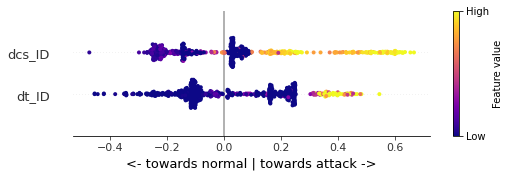

In [20]:
# plot_beeswarm(shap_all)
def plot_beeswarm2(exp_obj):
    vis = shap.plots.beeswarm(exp_obj, show=False, max_display=20, color=plt.get_cmap("plasma"), order=[1, 3], color_bar=False)
    # plt.gcf().axes[-1].set_aspect(100)
    # plt.gcf().axes[-1].set_box_aspect(100)
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap="plasma"), label="Feature value")
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(["Low", "High"])
    plt.xlabel("<- towards normal | towards attack ->")
    return vis

plot_beeswarm2(shap_all)

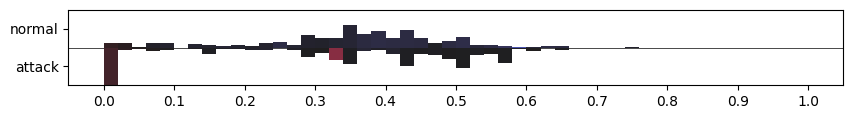

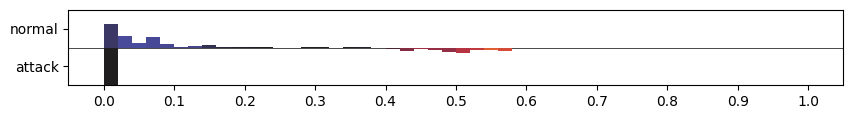

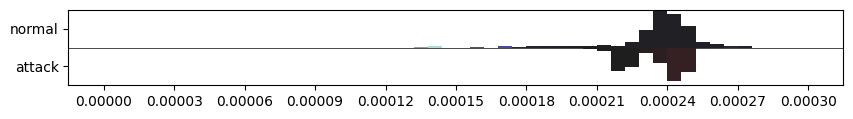

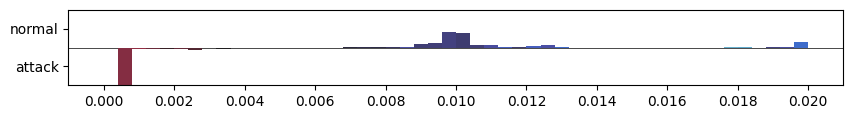

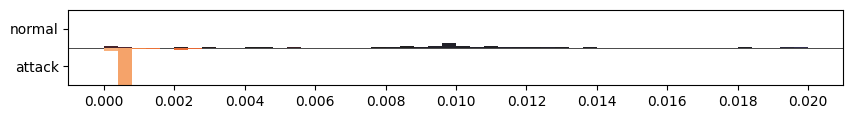

In [89]:
import matplotlib
def cust_exp(df_exp: pd.DataFrame, shap_all: shap.Explanation, feature, scale):
    df_exp["Label"].replace({0: "normal", 1: "attack"}, inplace=True)
    shap_exp = shap_all.values[:,df_exp.columns.get_loc(feature)]

    mask = (df_exp[feature] >= scale[0]) & (df_exp[feature] < scale[1])

    attack_outliers = shap_exp[~mask & (df_exp["Label"] == "attack")]
    normal_outliers = shap_exp[~mask & (df_exp["Label"] == "normal")]

    shap_exp = shap_exp[mask]
    df_exp = df_exp[mask].copy()
    
    scaler = max(abs(shap_exp.min()), abs(shap_exp.max()))
    shap_hues = shap_exp / scaler
    shap_hues = (shap_hues + 1) * shap_all.base_values[0]

    cmap = sns.color_palette("icefire", as_cmap=True)
    norm = plt.Normalize(vmin=0, vmax=1)
    palette = {h: cmap(h) for h in shap_hues}

    df_exp["shap_hues"] = shap_hues
    
    normal_values = df_exp.loc[df_exp["Label"] == "normal", [feature, "shap_hues"]]
    attack_values = df_exp.loc[df_exp["Label"] == "attack", [feature, "shap_hues"]]
    
    normal_hist, normal_bins = np.histogram(normal_values[feature], bins=50, range=(scale[0], scale[1]))
    attack_hist, attack_bins = np.histogram(attack_values[feature], bins=50, range=(scale[0], scale[1]))

    fig, ax = plt.subplots(dpi=100, figsize=(10, 1))
    
    max_bar = max(normal_hist.max(), attack_hist.max())
    normal_hist = normal_hist / max_bar
    attack_hist = attack_hist / max_bar

    normal_cont = ax.bar(normal_bins[:-1], normal_hist, width=(scale[1] - scale[0])/50, align="edge")
    attack_cont = ax.bar(attack_bins[:-1], -attack_hist, width=(scale[1] - scale[0])/50, align="edge")


    # display(normal_values)
    prev_edge = 0
    for i in range(1, len(normal_bins)):
        normal_hues_mean = normal_values.loc[(normal_values[feature] >= normal_bins[prev_edge]) & (normal_values[feature] < normal_bins[i]), "shap_hues"].fillna(0.5).mean()
        attack_hues_mean = attack_values.loc[(attack_values[feature] >= attack_bins[prev_edge]) & (attack_values[feature] < attack_bins[i]), "shap_hues"].fillna(0.5).mean()

        # print(shap_hues_mean)
        normal_cont.patches[i - 1].set_facecolor(cmap(normal_hues_mean))
        attack_cont.patches[i - 1].set_facecolor(cmap(attack_hues_mean))
        # attack_cont.patches[i - 1]

        prev_edge = i

    tick_unit = (scale[1] - scale[0]) / 10
    ax.set_xlim(scale[0] - 0.5*tick_unit, scale[1] + 0.5*tick_unit)
    ax.set_xticks(ticks=np.linspace(scale[0], scale[1], 11)) #, labels=map(lambda x: format(x, '.2f'), np.linspace(0, 0.02, 11)))
    ax.set_ylim(-1, 1)
    ax.set_yticks(ticks=[-0.5, 0.5], labels=["attack", "normal"])

    ax.axhline(y=0, color="black", linewidth=0.5, zorder=-1)

    plt.show()

cust_exp(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dcs", scale=(0, 1))
cust_exp(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dcs_ID", scale=(0, 1))
cust_exp(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dt", scale=(0, 0.0003))
cust_exp(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dt_ID", scale=(0, 0.02))
cust_exp(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dt_data", scale=(0, 0.02))

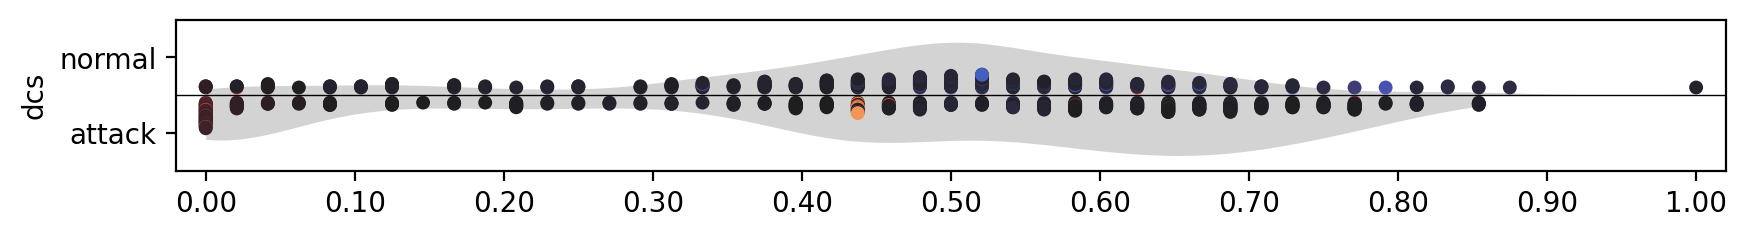

5.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
35.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


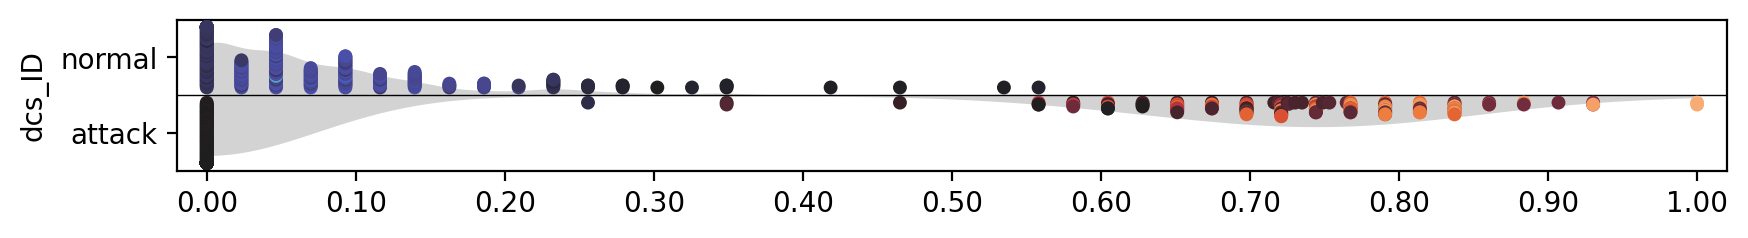

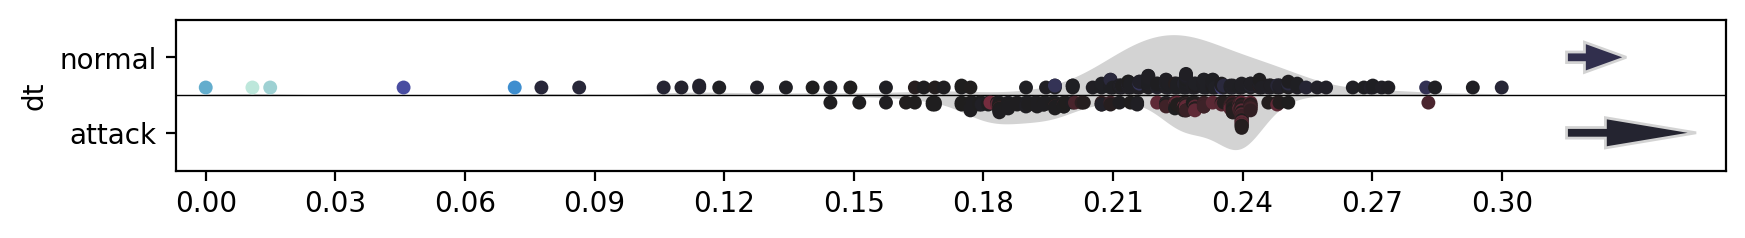

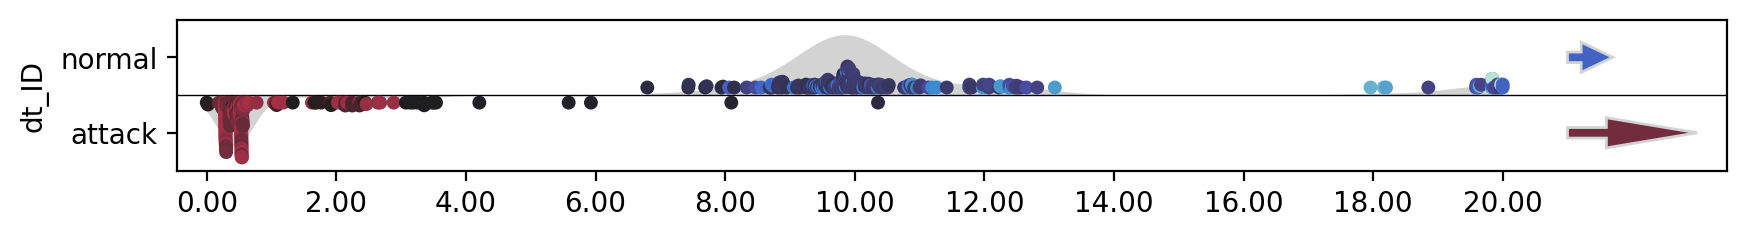

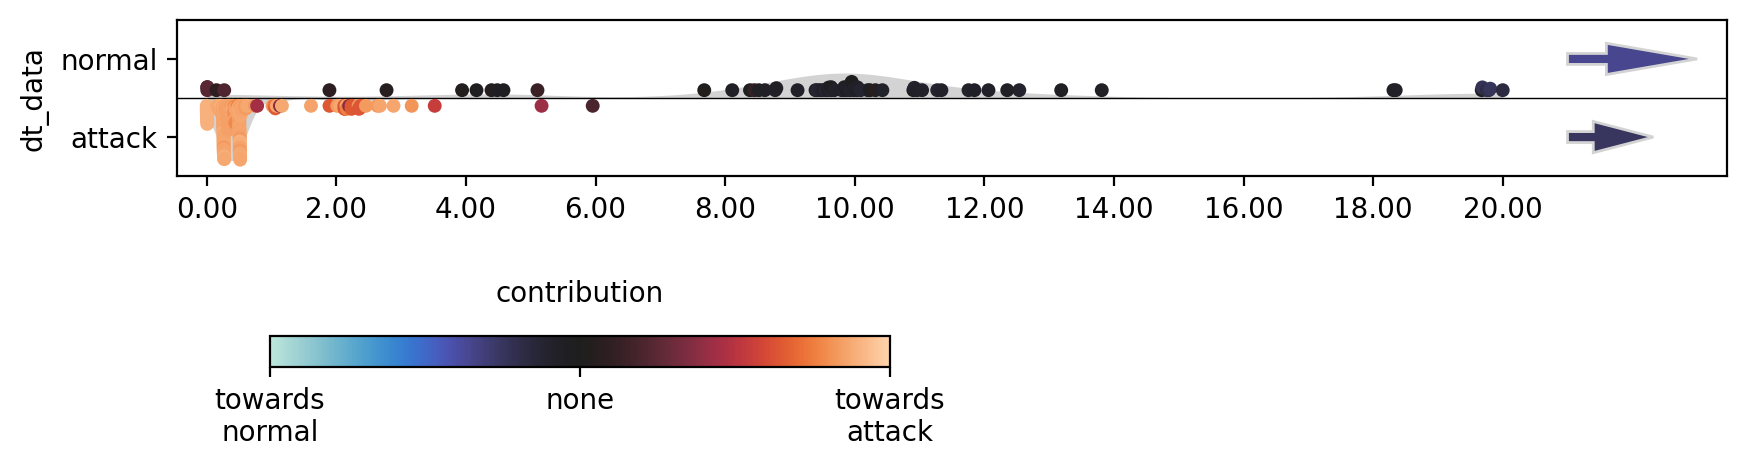

In [61]:
import matplotlib
def plot_test(df_exp: pd.DataFrame, shap_all: shap.Explanation, feature, trim=None, y_squish=10, scale=1, colorbar=False, y_size=1, minmax=None):
    df_exp["Label"].replace({0: "normal", 1: "attack"}, inplace=True)
    shap_exp = shap_all.values[:,df_exp.columns.get_loc(feature)]

    mask = None
    if trim == None:
        mask = (np.abs(stats.zscore(df_exp[feature])) < 3)
    else:
        mask = (df_exp[feature] > trim[0]) & (df_exp[feature] < trim[1])

    attack_outliers = shap_exp[~mask & (df_exp["Label"] == "attack")]
    normal_outliers = shap_exp[~mask & (df_exp["Label"] == "normal")]

    shap_exp = shap_exp[mask]
    df_exp = df_exp[mask]

    # plt.figure(dpi=200)
    # plt.figure(80, y_squish)
    # fig = plt.figure() 
    # ax = fig.add_axes([0, 0, 80, y_squish])
    fig, ax = plt.subplots(dpi=200, figsize=(80, y_squish))
    
    cmap_name = "icefire"
    violin_color = "lightgray"

    scaler = max(abs(shap_exp.min()), abs(shap_exp.max()))
    shap_hues = shap_exp / scaler
    shap_hues = (shap_hues + 1) * shap_all.base_values[0]

    if attack_outliers.size != 0:
        attack_outliers /= max(abs(attack_outliers.min()), abs(attack_outliers.max()))
        attack_outliers = (attack_outliers + 1) * shap_all.base_values[0]

    if normal_outliers.size != 0:
        normal_outliers /= max(abs(normal_outliers.min()), abs(normal_outliers.max()))
        normal_outliers = (normal_outliers + 1) * shap_all.base_values[0]
    
    cmap = sns.color_palette(cmap_name, as_cmap=True)
    norm = plt.Normalize(vmin=0, vmax=1)
    palette = {h: cmap(h) for h in shap_hues}

    values = df_exp[feature]
    feature_min = values.min()
    feature_max = values.max()
    values = (values - values.min()) / (values.max() - values.min())
    label = df_exp["Label"]

    sns.swarmplot(x=values, y=label, order=["normal", "attack"],
        hue=shap_hues, orient="h", palette=palette,
        size=5)
    
    # Change offset on dots for normal (0)
    offsets = ax.collections[0].get_offsets()
    offsets = [[elem[0], -abs(elem[1] - 0) - 0.05] for elem in offsets]
    ax.collections[0].set_offsets(offsets)

    # Change offset on dots for attack (1)
    offsets = ax.collections[1].get_offsets()
    offsets = [[elem[0], abs(elem[1] - 1) + 0.05] for elem in offsets]
    ax.collections[1].set_offsets(offsets)

    fig.set_size_inches(10, y_size)

    sns.violinplot(x=values, y=[0]*label.size, hue=label, split=True, hue_order=["normal", "attack"],
        orient="h",  showfliers=False, scale="count", bw=0.2, gridsize=1000, linewidth=0, color=violin_color,
        cut=0, inner=None)
    
    for violin in ax.findobj(matplotlib.collections.PolyCollection):
        violin.set_facecolor("lightgray")
    
    ax.legend_.remove()

    if colorbar:
        cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap_name), location="bottom", shrink=0.4, anchor=(0.10, 0), pad=0.4)
        cbar.set_label("contribution", labelpad=-60)
        cbar.set_ticks([0, 0.5, 1])
        cbar.set_ticklabels(["towards\nnormal", "none", "towards\nattack"])

        # plt.arrow(0, 0.5, 1, 0, facecolor="black",
        #     width=0.07, head_length=0.7, head_width=0.2,
        #     length_includes_head=True)

    # f_dict = {"dcs": "A", "dcs_ID": "A", "dt": "C", "dt_ID": "B", "dt_data": "E"}
    # feature = f_dict[feature]
    # ax.set_title(f"How the RF-model classifies data - feature: {feature}")
    # ax.set_title(feature)
    # feature = feature + " (ms)" if feature[0:2] == "dt" else feature

    # ax.set_ylabel("type of data")
    ax.set_ylabel(feature) #, rotation="vertical", x=-1, y=0.4)
    # ax.set_xlabel(f"value of {feature}")
    ax.set_xlabel("")

    if minmax == None:
        ax.set_xticks(ticks=np.linspace(0, 1, 11), labels=map(lambda x: format(x*scale, '.2f'), np.linspace(minmax[0], minmax[1], 11)))
    else:
        ax.set_xticks(ticks=np.linspace(0, 1, 11), labels=map(lambda x: format(x*scale, '.2f'), np.linspace(minmax[0], minmax[1], 11)))
    
    ax.set_yticks(ticks=[-0.25, 0.25], labels=["normal", "attack"])
    ax.axhline(y=0, color="black", linewidth=0.5)
    
    s_last = ax.get_xticks()[-2]
    last = ax.get_xticks()[-1]
    
    largest_outliers = max(len(normal_outliers), len(attack_outliers))

    if normal_outliers.size != 0:
        # ax.text(last + (last-s_last) * 0.5, -0.28, f"{len(normal_outliers)}")
        arrow_length = (last-s_last) * (len(normal_outliers) / largest_outliers)
        ax.arrow(last + (last-s_last) * 0.5, -0.25, arrow_length, 0, facecolor=cmap(normal_outliers.mean()), edgecolor=violin_color,
            width=0.07, head_length=(arrow_length)*0.7, head_width=0.2,
            length_includes_head=True)
    if attack_outliers.size != 0:
        # ax.text(last + (last-s_last) * 0.5, 0.22, f"{len(attack_outliers)}")
        arrow_length = (last-s_last) * (len(attack_outliers) / largest_outliers)
        ax.arrow(last + (last-s_last) * 0.5, 0.25, arrow_length, 0, facecolor=cmap(attack_outliers.mean()), edgecolor=violin_color,
            width=0.07, head_length=(arrow_length)*0.7, head_width=0.2,
            length_includes_head=True)
    
    ax.margins(x=0.02)
    
    # return ax
    plt.show()

plot_test(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dcs", trim=(-1, 1), y_squish=25, minmax=(0, 1))
plot_test(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dcs_ID", trim=(-1, 1), y_squish=15, minmax=(0, 1))
plot_test(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dt", trim=(0, 0.0003), scale=1000, y_squish=15, minmax=(0, 0.0003))
# plot_test(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dt_ID", trim=(0, 0.21), scale=1000)
plot_test(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dt_ID", trim=(0, 0.02), scale=1000, minmax=(0, 0.02))
plot_test(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dt_data", trim=(0, 0.02), scale=1000, colorbar=True, y_size=2.3, minmax=(0, 0.02))

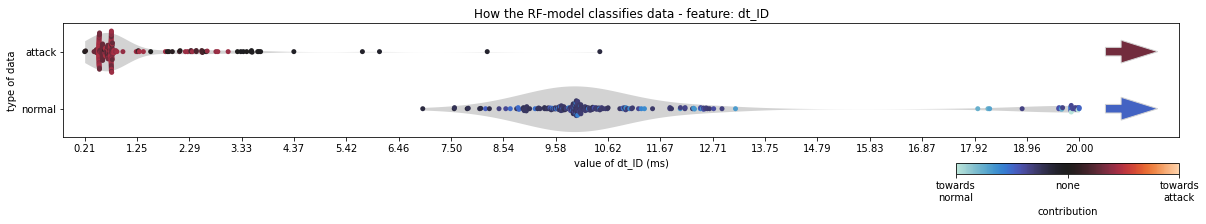

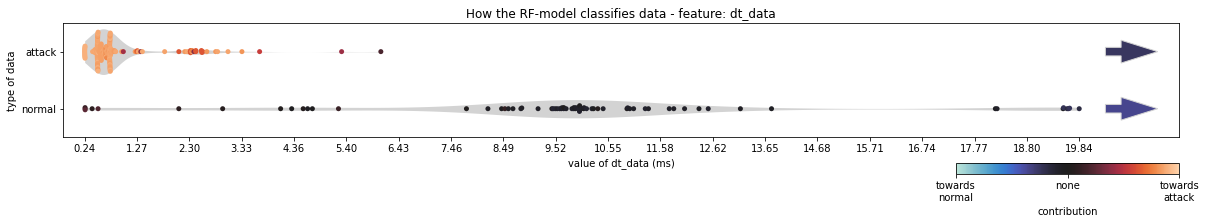

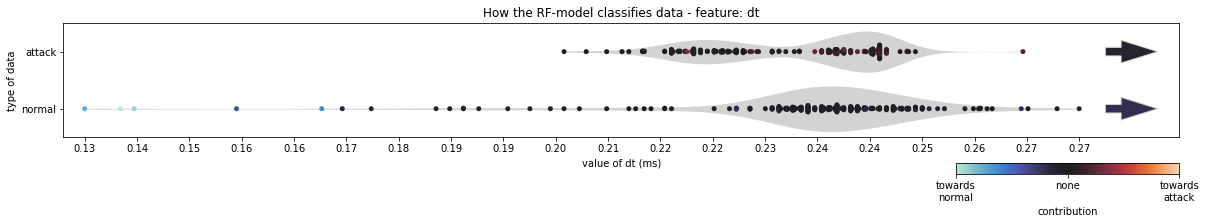

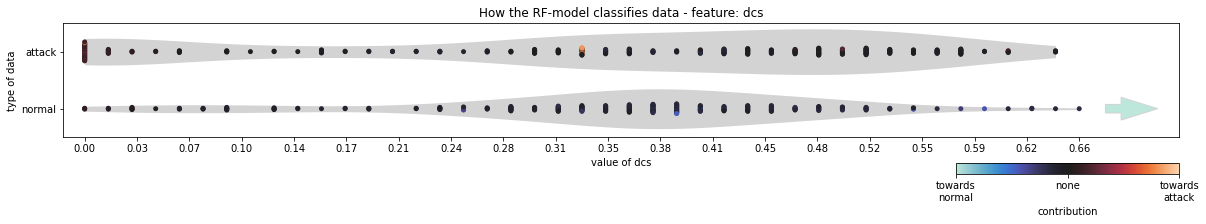

7.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


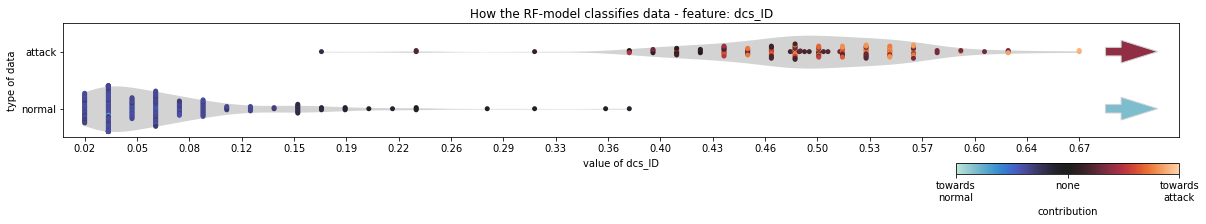

In [62]:
plot_exp(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dt_ID", trim=(0, 0.02), scale=1000)
plot_exp(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dt_data", trim=(0, 0.02), scale=1000)
plot_exp(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dt", trim=(0, 0.0003), scale=1000, y_squish=20)
plot_exp(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dcs", trim=(-1, 0.7), y_squish=25)
plot_exp(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dcs_ID", trim=(0, 1), y_squish=10)

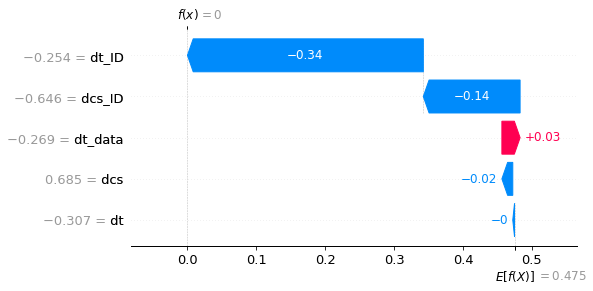

In [66]:
plot_waterfall(shap_all, 0)

In [67]:
plot_force(shap_all[0])

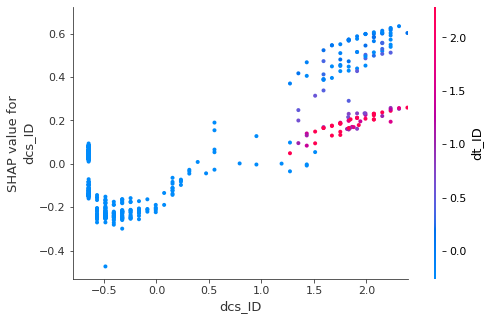

In [78]:
plot_dependence(shap_all, "dcs_ID", "dt_ID", xmax="percentile(99)")

In [19]:
dnn_layer_1 = keras.Model(inputs=dnn.input, outputs=dnn.get_layer("layer_3").output)

dnn_layer_1.predict(X_train)

array([[0.        , 2.0680475 , 0.        , ..., 0.        , 2.3630352 ,
        2.243791  ],
       [0.        , 1.7100167 , 0.        , ..., 0.        , 1.809918  ,
        1.7536744 ],
       [0.17535664, 1.4493308 , 0.        , ..., 0.        , 1.5298315 ,
        1.5848781 ],
       ...,
       [2.3730376 , 0.11246863, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [2.5577636 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [2.6439602 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [20]:
exp_layer_1 = shap.KernelExplainer(dnn_layer_1, data=X_train.sample(100, random_state=1))

In [21]:
shap_all_layer_1 = get_explanation(exp_layer_1, X_train, 100)

TypeError: get_explanation() takes 2 positional arguments but 3 were given

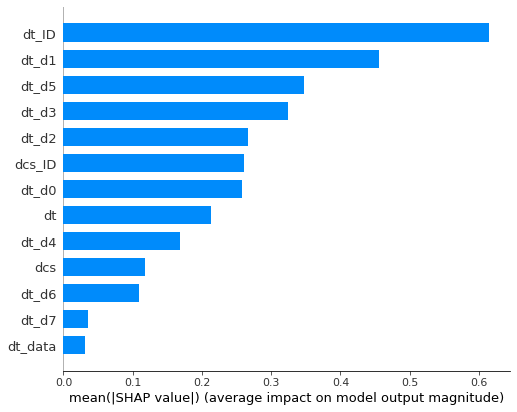

In [ ]:
# print(shap_all_layer_1)
shap.summary_plot(shap_all_layer_1, X_test, plot_type="bar")